# Assignment: More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.)

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

### 1. Reproduce the SST curve from the figure below

Use the `sst.mnmean.nc` file that we worked with in class, located at <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc>.

You don't have to match the stylistic details, or use different colors above and below zero, just the "3mth running mean" curve.

![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

Load the data as an Xarray dataset. Drop the `time_bnds` variable as we did in class and trim the data to 1950 onward for this assignment.

In [2]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1950', '2021')).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 862)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-10-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2021-11-07
    DODS_EXTRA.Unlimited_Dimension:  time

Now calculate the climatology and the SST anomaly.

In [3]:
gb = ds.sst.groupby('time.month')

# Global
sst_climatology_glob = gb.mean(dim='time')
sst_anomaly_glob = gb-sst_climatology_glob

# Nino 3.4 Region
gb_nino = ds.interp(lon=np.linspace(360-170,360-120,26), lat=np.linspace(-5,5,6)).sst.groupby('time.month')
sst_climatology_nino = gb_nino.mean(dim='time')
sst_anomaly_nino = gb_nino - sst_climatology_nino


Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.

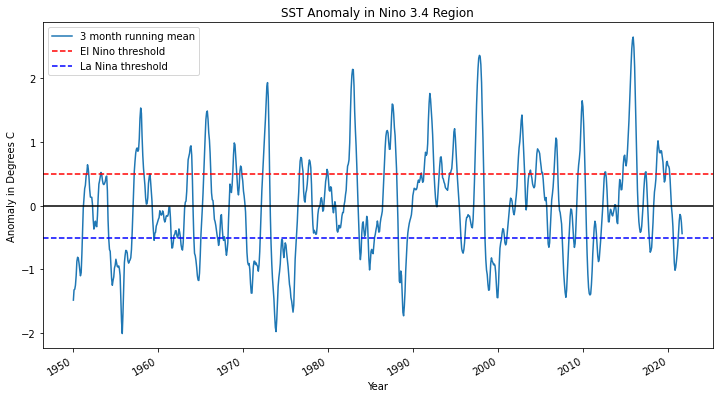

In [4]:
sst_anom_rolling = sst_anomaly_nino.rolling(time=3, center=True).mean().mean(dim=['lon','lat'])
sst_anom_rolling.plot(label='3 month running mean')
plt.xlabel("Year")
plt.ylabel("Anomaly in Degrees C")
plt.title("SST Anomaly in Nino 3.4 Region")
plt.axhline(y=0,color='k')
plt.axhline(y=0.5,color='r',linestyle='--',label='El Nino threshold')
plt.axhline(y=-0.5,color='b',linestyle='--',label='La Nina threshold')
plt.legend()

### 2. Calculate boolean timeseries representing the positive / negative ENSO phases

Refer to the definitions of warm/cold phases above.

In [5]:
# Get booleans over threshold
over_warm_threshold = sst_anom_rolling > 0.5
under_cold_threshold = sst_anom_rolling < -0.5

# Now the filtered_warm and filtered_cold data arrays only contain periods of 5 or more consecutive 3 month averages
filtered_warm = (over_warm_threshold.rolling(time=5, center=True).sum()==5).rolling(time=5,center=True).max()
filtered_cold = (under_cold_threshold.rolling(time=5, center=True).sum()==5).rolling(time=5,center=True).max()

Plot them somehow.

Text(0, 0.5, 'ENSO Phases')

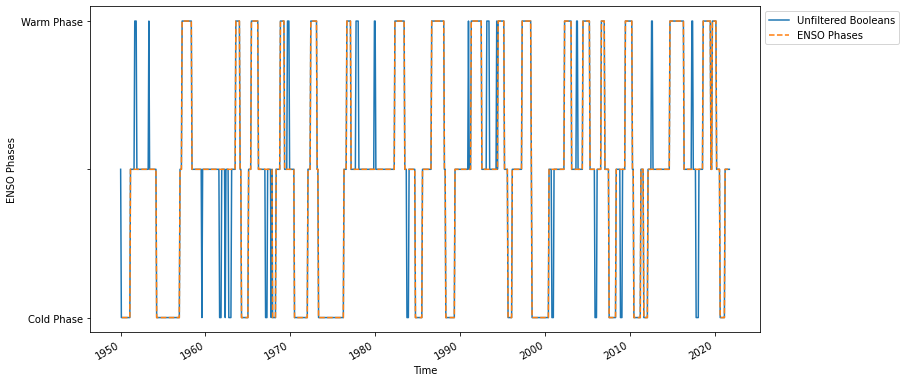

In [6]:
# For plotting, have the cold phase be negative
flip_under_raw = -under_cold_threshold.astype(int)
flip_filtered_cold = -filtered_cold

# Compare the highlighted ENSO phases with unfiltered booleans to make sure only periods of 5+ years selected
# Combine the cold and warm booleans into one boolean for plotting
# Unfiltered
combined_cold_warm_line_unfiltered = over_warm_threshold.astype(int) + flip_under_raw
combined_cold_warm_line_unfiltered.plot(label="Unfiltered Booleans")

# Filtered
combined_cold_warm_line = filtered_warm + flip_filtered_cold
combined_cold_warm_line.plot(linestyle='--',label="ENSO Phases")

plt.legend(bbox_to_anchor=(1, 1))
ticks = [-1,0,1]
labels = ["Cold Phase", " ", "Warm Phase"]
plt.yticks(ticks,labels)
plt.ylabel("ENSO Phases")

### 3. Plot composites of SST anomaly for the positive and negative ENSO regimes

These should be pcolormesh maps. First positive ONI.

Text(0.5, 1.0, 'SST anomaly composite for positive ENSO regimes')

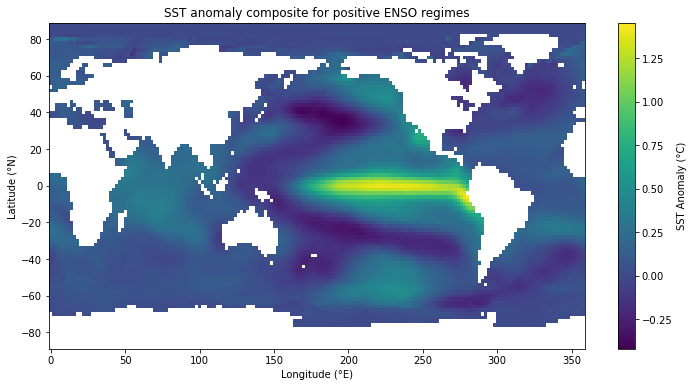

In [7]:
enso_pos_anom = sst_anomaly_glob.groupby(filtered_warm==1)[True].mean(dim='time')
plt.pcolormesh(enso_pos_anom.lon,enso_pos_anom.lat,enso_pos_anom,shading='auto')
cbar = plt.colorbar()
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
cbar.set_label("SST Anomaly (°C)")
plt.title("SST anomaly composite for positive ENSO regimes")

And negative ONI.

Text(0.5, 1.0, 'SST anomaly composite for negative ENSO regimes')

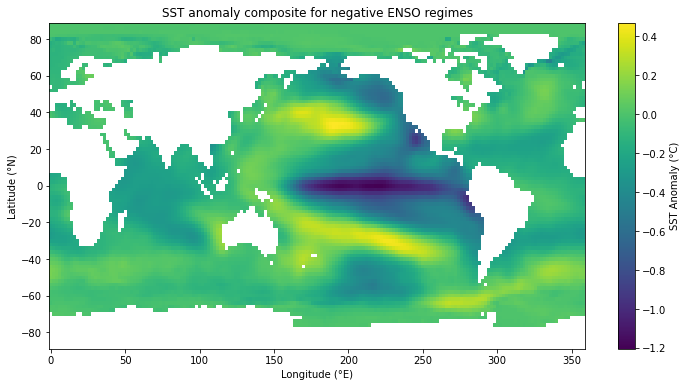

In [8]:
enso_neg_anom = sst_anomaly_glob.groupby(filtered_cold==1)[True].mean(dim='time')
plt.pcolormesh(enso_neg_anom.lon,enso_neg_anom.lat,enso_neg_anom,shading='auto')
cbar = plt.colorbar()
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
cbar.set_label("SST Anomaly (°C)")
plt.title("SST anomaly composite for negative ENSO regimes")

### 4. Calculate the composite of preciptiation for positive and negative ENSO phases.

First load the precip dataset. Code to fix the broken time coordinate is included.

In [9]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset>
Dimensions:  (X: 144, time: 361, Y: 72)
Coordinates:
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1990-01-01
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
Data variables:
    prcp     (time, Y, X) float32 nan nan nan nan ... 0.07234 0.06634 0.06526
Attributes:
    Conventions:  IRIDL

Now plot the *difference* between the time-mean of `prcp` during positive and negative ENSO phases.

Text(0.5, 1.0, 'Precipitation composite for difference in time-mean between positive and negative ENSO regimes')

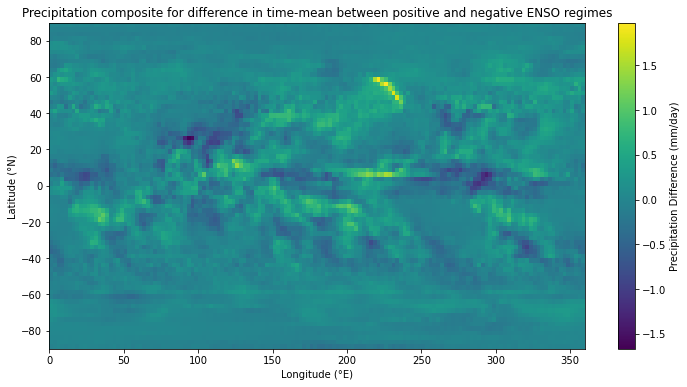

In [10]:
# first interpolate precip to fit our anomaly phases
prcp_interp = dsp.interp(time=ds.time)

prcp_pos_mean = prcp_interp.prcp.groupby(filtered_warm==1)[True].mean(dim='time')

prcp_neg_mean = prcp_interp.prcp.groupby(filtered_cold==1)[True].mean(dim='time')

prcp_mean_diff = prcp_pos_mean - prcp_neg_mean

plt.pcolormesh(prcp_mean_diff.X,prcp_mean_diff.Y,prcp_mean_diff,shading='auto')
cbar = plt.colorbar()
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
cbar.set_label("Precipitation Difference (mm/day)")
plt.title("Precipitation composite for difference in time-mean between positive and negative ENSO regimes")